In [1]:
# All the imports we need
import numpy as np
import gtsam
from gtsam.utils.plot import plot_pose3
from matplotlib import pyplot as plt
from gtsam.symbol_shorthand import B, V, X
from gtbook.display import show
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
from error_functions import error_depth, error_dvl, error_unary_heading, error_gps
from timesync_kalliyan import TimeSync
# from timesync import TimeSync


try:
  # For Google Colab
  from google.colab import output
  output.enable_custom_widget_manager()
  print(" -- Custom widgets enabled")
except:
  pass

# For interactive plots
%matplotlib widget


# a few helper functions

def vector3(x, y, z):
    """Create 3d double numpy array."""
    return np.array([x, y, z], dtype=float)

def gen_random_small_decimal():
   return np.random.randint(100) / 1000000

In [2]:
T = 12 # The timespan of our trajectory.
dt = 1e-2  # 100 Hz frequency
velocity = np.array([2, 0, 0])  # The velocity we wish to move at.



scenarios = {
    "zero_twist": (np.zeros(3), np.zeros(3)),  # Zero motion, stationary trajectory.
    "forward_motion": (np.zeros(3), velocity),  # Move forward in the x axis at 2 m/s.
    "loop": (np.array([0, -np.radians(5), 0]), velocity),  # A loop-de-loop trajectory.
    "sick": (np.array([np.radians(10), -np.radians(10), 0]), velocity)  # A spiral trajectory, "sick" in surfer slang.
}


def plot_scenario(scenario,
                  T,
                  dt,
                  title="IMU trajectory scenario",
                  fignum=0,
                  maxDim=5):
    for t in np.arange(0, T, dt):
        actualPose = scenario.pose(t)
        plot_pose3(fignum, actualPose, axis_length=0.3)

        translation = actualPose.translation()
        maxDim = max([max(np.abs(translation)), maxDim])
        ax = plt.gca()
        ax.set_xlim3d(-maxDim, maxDim)
        ax.set_ylim3d(-maxDim, maxDim)
        ax.set_zlim3d(-maxDim, maxDim)
        ax.set_title(title)
    

    plt.show()

In [3]:
accBias = np.array([-0.3, 0.1, 0.2])
gyroBias = np.array([0.1, 0.3, -0.1])
# accBias = np.array([-0.0, 0.0, 0.0])
# gyroBias = np.array([0.0, 0.0, -0.0])
actualBias = gtsam.imuBias.ConstantBias(accBias, gyroBias)

pim_params = gtsam.PreintegrationParams.MakeSharedU(9.81)

# Some arbitrary noise sigmas
gyro_sigma = 1e-3
accel_sigma = 1e-3
I_3x3 = np.eye(3)
pim_params.setGyroscopeCovariance(gyro_sigma**2 * I_3x3)
pim_params.setAccelerometerCovariance(accel_sigma**2 * I_3x3)
pim_params.setIntegrationCovariance(1e-7**2 * I_3x3)
g = 9.81
n_gravity = vector3(0, 0, -g)

BIAS_COVARIANCE = gtsam.noiseModel.Isotropic.Variance(6, 0.1)

# Define the PreintegratedImuMeasurements object here.
pim = gtsam.PreintegratedImuMeasurements(pim_params, actualBias)

# plot_scenario(scenario, T, dt, fignum=6)

In [4]:
# Unary stuff


# GPS 
std_gps = 6
GPS_NOISE = gtsam.noiseModel.Isotropic.Sigma(3, std_gps) 
def get_gps_measurement(t, scenario):
    rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.1)
    translationNoise = gtsam.Point3(*np.random.randn(3) * 0.1)
    poseNoise = gtsam.Pose3(rotationNoise, translationNoise)
    gps_pose = scenario.navState(t).pose().compose(poseNoise)
    return gtsam.Point3(gps_pose.x(), gps_pose.y(), gps_pose.z())

def generate_gps_measurements(scenario, T, dt_gps):
    gps_m = []
    for t in np.arange(0, T, dt_gps):
        rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.1)
        translationNoise = gtsam.Point3(*np.random.randn(3) * 0.1)
        poseNoise = gtsam.Pose3(rotationNoise, translationNoise)
        gps_pose = scenario.navState(t).pose().compose(poseNoise)
        m = gtsam.Point3(gps_pose.x(), gps_pose.y(), gps_pose.z())
        gps_m.append(m)
    return gps_m
        
        
    
# DVL
std_dvl_vel = np.array([0.1, 0.1, 0.1])
DVL_NOISE = gtsam.noiseModel.Diagonal.Sigmas(std_dvl_vel)
def get_dvl_measurement(t, scenario):
    velocity = scenario.navState(t).velocity() + np.random.randn(3) * 0.1
    return velocity

def generate_dvl_measurements(scenario, T, dt_dvl):
    dvl_m = []
    for t in np.arange(0, T, dt_dvl):
        velocity = scenario.navState(t).velocity() + np.random.randn(3) * 0.1
        dvl_m.append(velocity)
    print('DVL length: ',len(dvl_m))
    return dvl_m


# Heading
std_orientation = np.deg2rad(3)
HEADING_NOISE = gtsam.noiseModel.Isotropic.Sigma(3, std_orientation)
def get_orientation_measurement(t, scenario):
    rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.1)
    translationNoise = gtsam.Point3(*np.random.randn(3) * 1)
    poseNoise = gtsam.Pose3(rotationNoise, translationNoise)
    orientation_matrix = scenario.navState(t).pose().compose(poseNoise).rotation()
    return orientation_matrix


def generate_orientation_measurements(scenario, T, dt_orientation):
    orientation_m = []
    for t in np.arange(0, T, dt_orientation):
        rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.1)
        translationNoise = gtsam.Point3(*np.random.randn(3) * 1)
        poseNoise = gtsam.Pose3(rotationNoise, translationNoise)
        orientation_matrix = scenario.navState(t).pose().compose(poseNoise).rotation()
        orientation_m.append(orientation_matrix)
    print('Orientation length: ', len(orientation_m))
    return orientation_m




# Depth
std_depth = 0.1
DEPTH_NOISE = gtsam.noiseModel.Isotropic.Sigma(1, std_depth)
def get_depth_measurement(t, scenario):
    rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.1)
    translationNoise = gtsam.Point3(*np.random.randn(3) * 0.1)
    poseNoise = gtsam.Pose3(rotationNoise, translationNoise)
    gps_pose = scenario.navState(t).pose().compose(poseNoise)
    depth_meas = np.array([gps_pose.z()])
    return depth_meas

def generate_depth_measurements(scenario, T, dt_depth):
    depth_m = []
    for t in np.arange(0, T, dt_depth):
        rotationNoise = gtsam.Rot3.Expmap(np.random.randn(3) * 0.1)
        translationNoise = gtsam.Point3(*np.random.randn(3) * 0.1)
        poseNoise = gtsam.Pose3(rotationNoise, translationNoise)
        gps_pose = scenario.navState(t).pose().compose(poseNoise)
        depth_meas = np.array([gps_pose.z()])
        depth_m.append(depth_meas)
    return depth_m
    








In [5]:
isam = gtsam.ISAM2()
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

In [6]:
def add_priors(scenario, graph, initial, isam, posekey_to_time, velkey_to_time, T):
    # Noise models for
    priorNoise = gtsam.noiseModel.Isotropic.Sigma(6, 0.1)
    velNoise = gtsam.noiseModel.Isotropic.Sigma(3, 0.1)

    initial_state = scenario.navState(0)
    graph.push_back(
        gtsam.PriorFactorPose3(X(0), initial_state.pose(), priorNoise))
    graph.push_back(
        gtsam.PriorFactorVector(V(0), initial_state.velocity(), velNoise))
    
    graph.push_back(gtsam.PriorFactorConstantBias(B(0), actualBias, gtsam.noiseModel.Isotropic.Sigma(6, 0.1)))

    initial.insert(B(0), actualBias)
    initial.insert(X(0), initial_state.pose())
    posekey_to_time[X(0)] = 0.
    initial.insert(V(0), initial_state.velocity())
    velkey_to_time[V(0)] = 0.

        

    isam.update(graph, initial)
    result = isam.calculateEstimate()
    graph = gtsam.NonlinearFactorGraph()
    initial.clear()

    
    return graph, initial, isam, result, initial_state, posekey_to_time, velkey_to_time





In [7]:
def simulate(runner, scenario, graph, initial, isam, T):


    ###########################################################
    ################## ROS 2 NODE INIT START ##################
    ###########################################################

    # simulated Sensor Rates (these would not be in the ros2 node, just for sim purposes
    dt_gps = 1/1 # ~ 1 Hz
    dt_dvl = 1/6 # ~ 6 Hz
    dt_depth = 1/20 # ~ 20 Hz
    dt_orientation = 1/10 # ~ 10 Hz
    # sensor_rates = {'gps': dt_gps, 'dvl': dt_dvl, 'depth': dt_depth, 'orientation': dt_orientation}
    # simulated sensor measurements
    gps_scenario = generate_gps_measurements(scenario, T, dt_gps)
    orientation_scenario = generate_orientation_measurements(scenario, T, dt_orientation)
    dvl_scenario = generate_dvl_measurements(scenario, T, dt_dvl)
    depth_scenario = generate_depth_measurements(scenario, T, dt_depth)
    # sensor_scenarios = {'gps': gps_scenario, 'orientation'}

    # queue's to be filled up
    q_gps = TimeSync()
    q_dvl = TimeSync()
    q_depth = TimeSync()
    q_orientation = TimeSync()

    # maps for times of estimates
    posekey_to_time = {}
    velkey_to_time = {}

    # The factor index for the estimation rate
    i = 0

    # Periods in seconds
    FACTOR_GRAPH_PERIOD = 1 
   
    # DVL_PERIOD = 
    bias_key = B(0)

    deployed = False

    
    ###########################################################
    ####################### ROS 2 NODE INIT END ###############
    ###########################################################



    ###########################################################
    ##################### SIM LOOP START ######################
    ###########################################################

    # this is a loop that simulates going the rate of the IMU
    for k, t in enumerate(np.arange(0, T, dt)):
        # get measurements and add them to PIM

        # IMU: simulating IMU ros2 callback at 100 Hz
        if deployed:
            measuredOmega = runner.measuredAngularVelocity(t)
            measuredAcc = runner.measuredSpecificForce(t)
            pim.integrateMeasurement(measuredAcc, measuredOmega, dt)
        # GPS: simulating gps ros2 subscriber (1 Hz)
        if k % int(dt_gps * int(1 / dt)) == 0 and deployed: # GPS every second, each k represents 100th of a second because IMU is at 100 Hz
            time_stamp_gps = t + gen_random_small_decimal()
            q_gps.add_to_queue((gps_scenario.pop(0), time_stamp_gps)) # add a tuple with measurement and time
            print('length of GPS: ', len(gps_scenario))

        # DVL: simulating dvl ros2 subscriber (6 Hz)
        if k % int(dt_dvl * int(1 / dt)) == 0 and deployed: # dvl every 6th of a second (k = 60*n ticks)
            time_stamp_dvl = t + gen_random_small_decimal()
            q_dvl.add_to_queue((dvl_scenario.pop(0), time_stamp_dvl))
            print('length of DVL: ', len(dvl_scenario))

        # HEADING: simulating heading ros2 subscriber (10 Hz)
        if k % int(dt_orientation * int(1 / dt)) == 0 and deployed: # modem every 10th of a second (k = 10*n ticks)
            time_stamp_orientaion = t + gen_random_small_decimal()
            q_orientation.add_to_queue((orientation_scenario.pop(0), time_stamp_orientaion))
            print('length of orientation: ', len(orientation_scenario))

        # DEPTH: simulating depth ros2 subscriber (20 Hz)
        if k % int(dt_depth * int(1 / dt)) == 0 and deployed: # depth every 20th of a second (k = 5*n ticks)
            time_stamp_depth = t + gen_random_small_decimal()
            q_depth.add_to_queue((depth_scenario.pop(0), time_stamp_depth))
            print('length of depth: ', len(depth_scenario))
        
        # ADD PRIOR CALLBACK: Simulating the add priors init factor graph callback
        if deployed == False:
            graph, initial, isam, result, initial_state, posekey_to_time, velkey_to_time = add_priors(scenario, graph, initial, isam, posekey_to_time, velkey_to_time, T)
            prev_state = initial_state
            deployed = True # so that you only add priors once

        
        # Simulating Factor Graph ros2 timer callback @ 1 tick per second in this case
        if (k + 1) % int((1 / dt) * FACTOR_GRAPH_PERIOD) == 0 and deployed:
            # Create IMU factor every second.
            if i == 0: # when k = 99
                predicted_state_imu_dead_reckoning = pim.predict(prev_state, actualBias)
                initial.insert(X(1), predicted_state_imu_dead_reckoning.pose())
                initial.insert(V(1), predicted_state_imu_dead_reckoning.velocity())
                prev_state = predicted_state_imu_dead_reckoning
                posekey_to_time[X(1)] = t
                velkey_to_time[V(1)] = t
            elif i >= 2:
                predicted_state_imu_dead_reckoning = pim.predict(prev_state, actualBias)
                initial.insert(X(i), predicted_state_imu_dead_reckoning.pose())
                initial.insert(V(i), predicted_state_imu_dead_reckoning.velocity())
                prev_state = predicted_state_imu_dead_reckoning
                posekey_to_time[X(i)] = t
                velkey_to_time[V(i)] = t
                

            if i > 0:

                if i % 5 == 0:
                    bias_key += 1
                    initial.insert(bias_key, actualBias)
                    # note that gtsam.imuBias.ConstantBias() defaults to zeroes
                    bias_between_factor = gtsam.BetweenFactorConstantBias(bias_key - 1, bias_key, gtsam.imuBias.ConstantBias(), BIAS_COVARIANCE)
                    graph.add(bias_between_factor)

                

                factor = gtsam.ImuFactor(X(i - 1), V(i - 1), X(i), V(i), bias_key, pim)
                graph.push_back(factor)

                # We have created the binary constraint, so we clear out the preintegration values.
                pim.resetIntegration()

                # add unaries

                # GPS: constrain pose x y z estimate
                # print('GPS messages: ', q_gps.msg_queue)
                # print("\n\nPose key to time dict: ", posekey_to_time, "Initial Node of Interest: ", X(i))
                # poseKey_to_add, meas_to_add, msg_time = q_gps.get_factor_info(X(i), posekey_to_time, X(0))
                # if meas_to_add is not None and poseKey_to_add is not None:
                #     print(f'GPS time {msg_time} matched to {posekey_to_time[poseKey_to_add]}')
                #     graph.add(gtsam.CustomFactor(GPS_NOISE, [poseKey_to_add], partial(error_gps, meas_to_add)))

                # Heading Unaries: constrain orientation
                # print('Orientation messages: ', q_orientation.msg_queue)
                # print("\n\nPose key to time dict: ", posekey_to_time, "Initial Node of Interest: ", X(i))
                # poseKey_to_add, meas_to_add, msg_time = q_orientation.get_factor_info(X(i), posekey_to_time, X(0))
                # if poseKey_to_add is not None and meas_to_add is not None:
                #     print(f'Heading time {msg_time} matched to {posekey_to_time[poseKey_to_add]}')
                #     graph.add(gtsam.CustomFactor(HEADING_NOISE, [X(i)],partial(error_unary_heading, [meas_to_add])))
                

                # # Depth Unaries: constrains z component of pose estimate
                # print('Depth messages: ', q_depth.msg_queue)
                # print("\n\nPose key to time dict: ", posekey_to_time, "Initial Node of Interest: ", X(i))
                # poseKey_to_add, meas_to_add, msg_time = q_depth.get_factor_info(X(i), posekey_to_time, X(0))
                # if poseKey_to_add is not None and meas_to_add is not None:
                #     print(f'Depth time {msg_time} matched to {posekey_to_time[poseKey_to_add]}')
                #     graph.add(gtsam.CustomFactor(DEPTH_NOISE, [X(i)], partial(error_depth, [meas_to_add])))

                # # DVL: Constrains velocity x y z
                # poseKey_to_add, meas_to_add, msg_time = q_dvl.get_factor_info(V(i), posekey_to_time, V(0))
                # if poseKey_to_add is not None and meas_to_add is not None:
                #     print(f'DVL time {msg_time} matched to {velkey_to_time[poseKey_to_add]}')
                #     graph.add(gtsam.CustomFactor(DVL_NOISE, [V(i)], partial(error_dvl, [meas_to_add]) ))
                

            isam.update(graph, initial)
            result = isam.calculateEstimate()
            graph = gtsam.NonlinearFactorGraph()
            initial.clear()

            i += 1

        ###########################################################
        ##################### SIM LOOP END   ######################
        ###########################################################


    return graph, result

In [8]:
def plot_trajectory(values: gtsam.Values,
                    title: str = "Estimated Trajectory",
                    fignum: int = 1,
                    show: bool = False):
    i = 0
    while values.exists(X(i)):
        pose_i = values.atPose3(X(i))
        plot_pose3(fignum, pose_i, 1)
        i += 1
    plt.title(title)

    gtsam.utils.plot.set_axes_equal(fignum)

    plt.ioff()

    if show:
        plt.show()

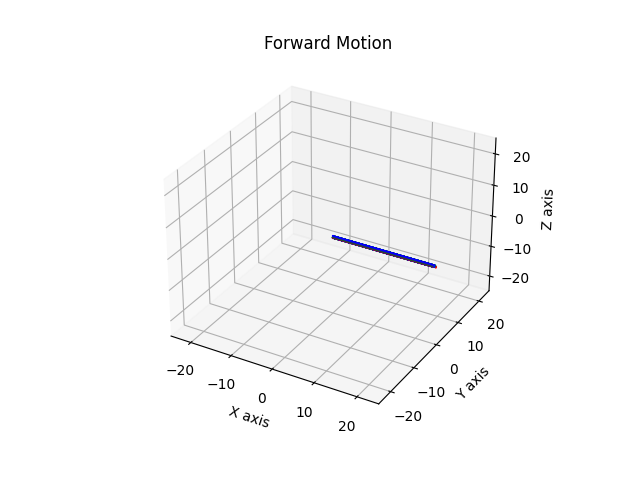

Orientation length:  120
DVL length:  72
length of depth:  239
length of orientation:  119
length of depth:  238
length of depth:  237
length of DVL:  71
length of orientation:  118
length of depth:  236
length of depth:  235
length of orientation:  117
length of depth:  234
length of DVL:  70
length of depth:  233
length of orientation:  116
length of depth:  232
length of depth:  231
length of DVL:  69
length of orientation:  115
length of depth:  230
length of depth:  229
length of orientation:  114
length of depth:  228
length of DVL:  68
length of depth:  227
length of orientation:  113
length of depth:  226
length of depth:  225
length of DVL:  67
length of orientation:  112
length of depth:  224
length of depth:  223
length of orientation:  111
length of depth:  222
length of depth:  221
length of DVL:  66
length of GPS:  11
length of orientation:  110
length of depth:  220
length of depth:  219
length of orientation:  109
length of depth:  218
length of DVL:  65
length of depth

IndexError: pop from empty list

In [9]:

scenario = gtsam.ConstantTwistScenario(*scenarios["forward_motion"])
plot_scenario(scenario, T, dt, title="Forward Motion", fignum=1)
runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)
# graph, initial, isam, result = add_priors(scenario, graph, initial, isam)
graph, result = simulate(runner, scenario, graph, initial, isam, T)
# print(result)

plot_trajectory(result, title="ISAM Estimate", fignum=7, show=True)

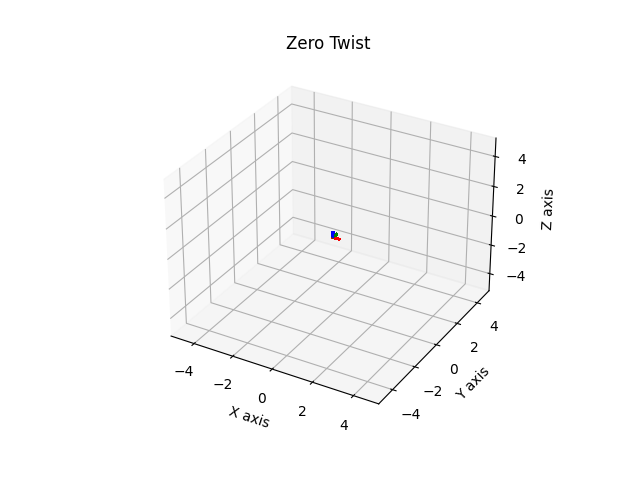

Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99} Initial Node of Interest:  8646911284551352321
Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99, 8646911284551352322: 2.99} Initial Node of Interest:  8646911284551352322
Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99, 8646911284551352322: 2.99, 8646911284551352323: 3.99} Initial Node of Interest:  8646911284551352323
Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99, 8646911284551352322: 2.99, 8646911284551352323: 3.99, 8646911284551352324: 4.99} Initial Node of Interest:  8646911284551352324
Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99, 8646911284551352322: 2.99, 8646911284551352323: 3.99, 8646911284551352324: 4.99, 8646911284551352325: 5.99} Initial Node of Interest:  864691128455135

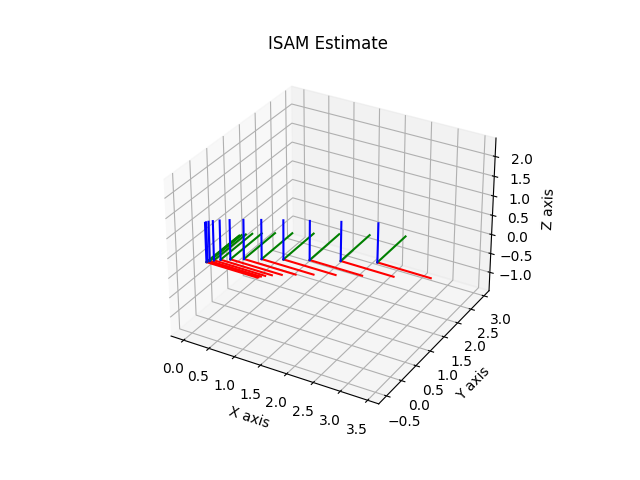

In [ ]:
scenario = gtsam.ConstantTwistScenario(*scenarios["zero_twist"])
plot_scenario(scenario, T, dt, title="Zero Twist", fignum=8)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
isam = gtsam.ISAM2()

# graph, initial, isam, result = add_priors(scenario, graph, initial, isam)
graph, result = simulate(runner, scenario, graph, initial, isam, T)
plot_trajectory(result, title="ISAM Estimate", fignum=9, show=True)



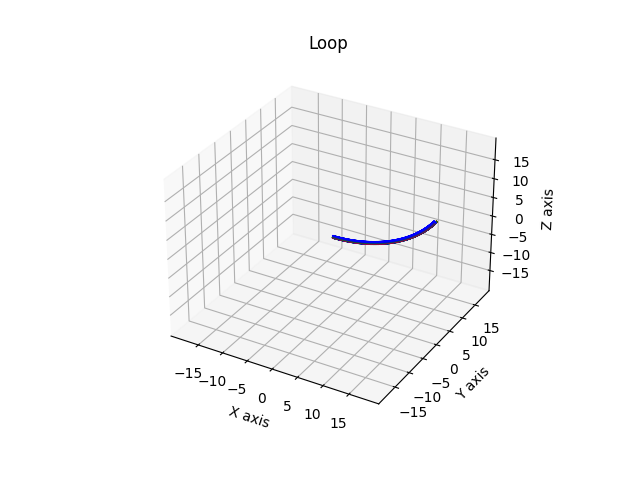

Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99} Initial Node of Interest:  8646911284551352321
Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99, 8646911284551352322: 2.99} Initial Node of Interest:  8646911284551352322
Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99, 8646911284551352322: 2.99, 8646911284551352323: 3.99} Initial Node of Interest:  8646911284551352323
Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99, 8646911284551352322: 2.99, 8646911284551352323: 3.99, 8646911284551352324: 4.99} Initial Node of Interest:  8646911284551352324
Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99, 8646911284551352322: 2.99, 8646911284551352323: 3.99, 8646911284551352324: 4.99, 8646911284551352325: 5.99} Initial Node of Interest:  864691128455135

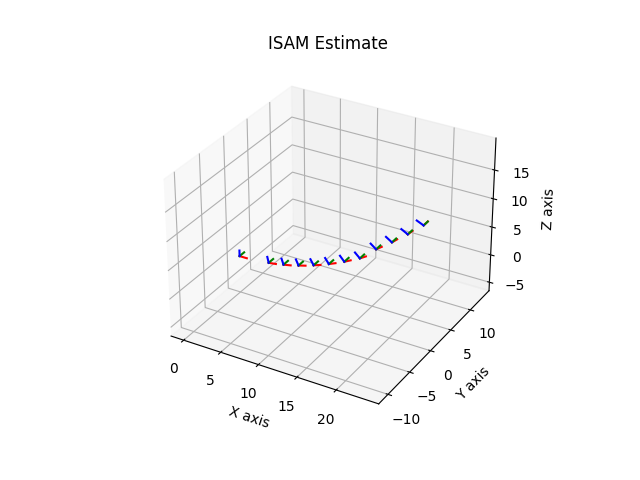

In [ ]:
scenario = gtsam.ConstantTwistScenario(*scenarios["loop"])
plot_scenario(scenario, T, dt, title="Loop", fignum=10)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
isam = gtsam.ISAM2()

# graph, initial, isam, result = add_priors(scenario, graph, initial, isam)
graph, result = simulate(runner, scenario, graph, initial, isam, T)
plot_trajectory(result, title="ISAM Estimate", fignum=11, show=True)

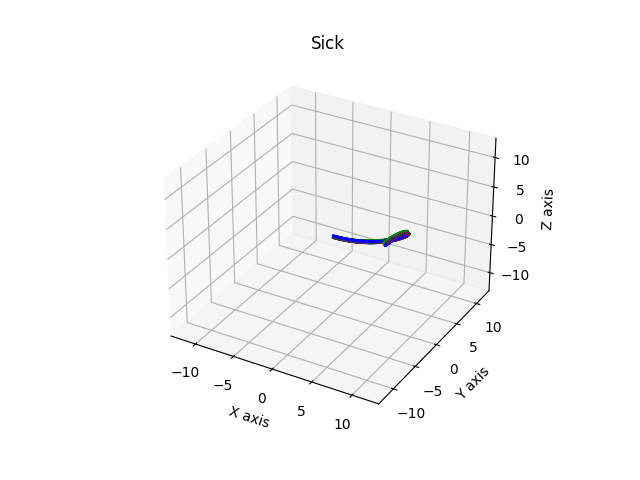

Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99} Initial Node of Interest:  8646911284551352321
Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99, 8646911284551352322: 2.99} Initial Node of Interest:  8646911284551352322
Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99, 8646911284551352322: 2.99, 8646911284551352323: 3.99} Initial Node of Interest:  8646911284551352323
Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99, 8646911284551352322: 2.99, 8646911284551352323: 3.99, 8646911284551352324: 4.99} Initial Node of Interest:  8646911284551352324
Depth messages:  []


Pose key to time dict:  {8646911284551352320: 0.0, 8646911284551352321: 0.99, 8646911284551352322: 2.99, 8646911284551352323: 3.99, 8646911284551352324: 4.99, 8646911284551352325: 5.99} Initial Node of Interest:  864691128455135

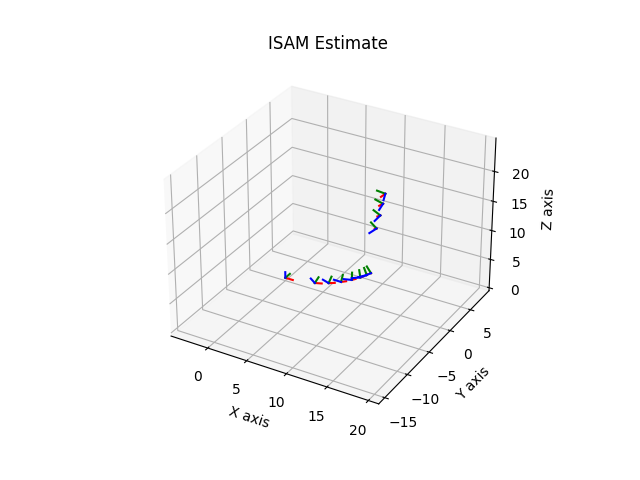

In [ ]:
scenario = gtsam.ConstantTwistScenario(*scenarios["sick"])
plot_scenario(scenario, T, dt, title="Sick", fignum=12)

runner = gtsam.ScenarioRunner(scenario, pim_params, dt, actualBias)


graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()
isam = gtsam.ISAM2()

# graph, initial, isam, result = add_priors(scenario, graph, initial, isam)
graph, result = simulate(runner, scenario, graph, initial, isam, T)
plot_trajectory(result, title="ISAM Estimate", fignum=13, show=True)